In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set_theme()

In [3]:
log_file = "../../remote/qiskit-qulacs-comparison-amd/qlbm.log"
with open(log_file, "r") as f:
    lines = f.readlines()

session_line = [c for c, line in enumerate(lines) if "Session" in line][1]

lines_statevector_true = lines[:session_line]
lines_statevector_false = lines[session_line:]

In [4]:
# Process statevector=True lines
combination_lines_indices = [
    c for c, line in enumerate(lines_statevector_true) if "Combination #" in line
]

sections = [
    lines_statevector_true[
        combination_lines_indices[c] : combination_lines_indices[c + 1]
        if c < len(combination_lines_indices)
        else session_line
    ]
    for c in range(len(combination_lines_indices) - 1)
]

statevector_true_records = []
for section in sections:
    sec_info = section[1].split("INFO: ")[-1].rstrip().split(", ")
    time_elapsed_ns = section[-1].split("INFO: ")[-1].rstrip().split()[-2]
    step_simulation_line_indices = [
        c for c, line in enumerate(section) if "Main circuit for step" in line
    ]
    qiskit_start = [
        c for c, line in enumerate(section) if "Executing QISKIT..." in line
    ][0]
    total_duration = 0
    for sl in step_simulation_line_indices:
        step_number = section[sl].split("for step ")[-1].split()[0]
        props = section[sl].split("INFO: ")[-1].rstrip().split(", ")[1:]
        duration = section[sl + 1].split()[-2]
        total_duration += int(duration)

        statevector_true_records.append(
            {
                "Lattice": sec_info[0].split("=")[-1].split("/")[-1].split(".")[0],
                "Dimensions": sec_info[0]
                .split("=")[-1]
                .split("/")[-1]
                .split(".")[0]
                .split("_")[1],
                "Obstacles": sec_info[0]
                .split("=")[-1]
                .split("/")[-1]
                .split(".")[0]
                .split("_")[2],
                "Circuit Qubits": int(sec_info[1].split("=")[-1]),
                "Step": int(step_number),
                "Depth": int(props[1]),
                "Gates": int(props[-1][:-1]),
                "Duration (ns)": int(duration),
                "Cumulative Duration (ns)": int(total_duration),
                "Snapshots": True,
                "Platform": "QISKIT"
                if sl > qiskit_start
                else "QULACS",  # Qulacs is first in this simulation
            }
        )

sv_true_df = pd.DataFrame.from_records(statevector_true_records)
sv_true_df

,Lattice,Dimensions,Obstacles,Circuit Qubits,Step,Depth,Gates,Duration (ns),Cumulative Duration (ns),Snapshots,Platform
0,2d_8x8_1_obstacle,8x8,1,18,0,0,0,309925939,309925939,True,QULACS
1,2d_8x8_1_obstacle,8x8,1,18,1,109873,193974,10022965621,10332891560,True,QULACS
2,2d_8x8_1_obstacle,8x8,1,18,2,109873,193974,10223844980,20556736540,True,QULACS
3,2d_8x8_1_obstacle,8x8,1,18,3,109873,193974,10236385805,30793122345,True,QULACS
4,2d_8x8_1_obstacle,8x8,1,18,4,109873,193974,10257262461,41050384806,True,QULACS
...,...,...,...,...,...,...,...,...,...,...,...
65,2d_32x32_2_obstacle,32x32,2,22,0,1,2,8122892862,22456090589482,True,QISKIT
66,2d_32x32_2_obstacle,32x32,2,22,1,404781,749234,641606516931,23097697106413,True,QISKIT
67,2d_32x32_2_obstacle,32x32,2,22,2,404781,749234,640598655421,23738295761834,True,QISKIT
68,2d_32x32_2_obstacle,32x32,2,22,3,404781,749234,628835572915,24367131334749,True,QISKIT


In [5]:
# Process statevector=False lines
combination_lines_indices = [
    c for c, line in enumerate(lines_statevector_false) if "Combination #" in line
]

sections = [
    lines_statevector_false[
        combination_lines_indices[c] : combination_lines_indices[c + 1]
        if c < len(combination_lines_indices)
        else -1
    ]
    for c in range(len(combination_lines_indices) - 1)
]

statevector_false_records = []
for section in sections:
    sec_info = section[1].split("INFO: ")[-1].rstrip().split(", ")
    time_elapsed_ns = section[-1].split("INFO: ")[-1].rstrip().split()[-2]
    step_simulation_line_indices = [
        c for c, line in enumerate(section) if "Main circuit for step" in line
    ]
    qiskit_start = [
        c for c, line in enumerate(section) if "Executing QISKIT..." in line
    ][0]
    total_duration = 0
    for sl in step_simulation_line_indices:
        step_number = section[sl].split("for step ")[-1].split()[0]
        props = section[sl].split("INFO: ")[-1].rstrip().split(", ")[1:]
        duration = section[sl + 1].split()[-2]

        total_duration += int(duration)
        statevector_false_records.append(
            {
                "Lattice": sec_info[0].split("=")[-1].split("/")[-1].split(".")[0],
                "Dimensions": sec_info[0]
                .split("=")[-1]
                .split("/")[-1]
                .split(".")[0]
                .split("_")[1],
                "Obstacles": sec_info[0]
                .split("=")[-1]
                .split("/")[-1]
                .split(".")[0]
                .split("_")[2],
                "Circuit Qubits": int(sec_info[1].split("=")[-1]),
                "Step": int(step_number),
                "Depth": int(props[1]),
                "Gates": int(props[-1][:-1]),
                "Duration (ns)": int(duration),
                "Cumulative Duration (ns)": int(total_duration),
                "Snapshots": False,
                "Platform": "QISKIT"
                if sl > qiskit_start
                else "QULACS",  # Qulacs is first in this simulation
            }
        )

sv_false_df = pd.DataFrame.from_records(statevector_false_records)
sv_false_df

,Lattice,Dimensions,Obstacles,Circuit Qubits,Step,Depth,Gates,Duration (ns),Cumulative Duration (ns),Snapshots,Platform
0,2d_8x8_1_obstacle,8x8,1,18,0,1,1,573231364,573231364,False,QISKIT
1,2d_8x8_1_obstacle,8x8,1,18,1,109877,193975,8251010791,8824242155,False,QISKIT
2,2d_8x8_1_obstacle,8x8,1,18,2,219733,387949,15031356746,23855598901,False,QISKIT
3,2d_8x8_1_obstacle,8x8,1,18,3,329589,581923,22211210459,46066809360,False,QISKIT
4,2d_8x8_1_obstacle,8x8,1,18,4,439445,775897,29441078409,75507887769,False,QISKIT
5,2d_8x8_2_obstacle,8x8,2,18,0,1,1,569139978,569139978,False,QISKIT
6,2d_8x8_2_obstacle,8x8,2,18,1,219935,385807,14619673348,15188813326,False,QISKIT
7,2d_8x8_2_obstacle,8x8,2,18,2,439849,771613,28914831805,44103645131,False,QISKIT
8,2d_8x8_2_obstacle,8x8,2,18,3,659763,1157419,43505451354,87609096485,False,QISKIT
9,2d_8x8_2_obstacle,8x8,2,18,4,879677,1543225,57788192889,145397289374,False,QISKIT


In [6]:
cdf = pd.concat([sv_true_df])
cdf["Duration (s)"] = cdf["Duration (ns)"] / 1e9
cdf["Cumulative Duration (s)"] = cdf["Cumulative Duration (ns)"] / 1e9


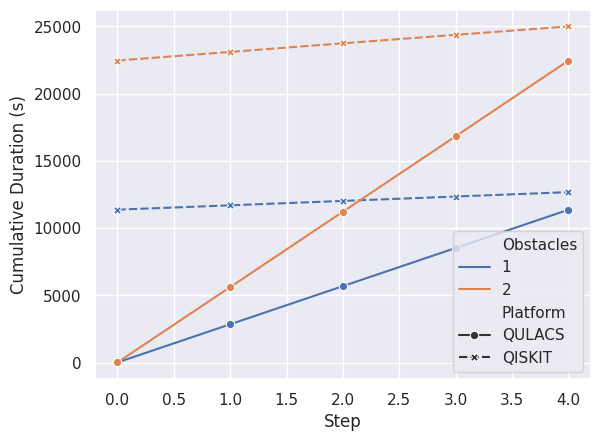

In [7]:
pdf = cdf[cdf["Dimensions"].isin(["32x32"])]
# pdf = pdf[pdf["Obstacles"] == 1]
sns.lineplot(
    pdf,
    x="Step",
    y="Cumulative Duration (s)",
    hue="Obstacles",
    style="Platform",
    markers=True,
)
plt.savefig("bad_qulacs_plot.pdf", format="pdf")